In [1]:
import copy
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from Dataset import Dataset
from torch.utils.data import DataLoader
torch.set_default_dtype(torch.float64)

In [2]:
def f(x, y, z, w):
    return -x**4+200*x+y**4-200*y-z**4+200*z-w**4+200*w

num_of_samples = 20
x_data = np.float64(np.linspace(-5, 5, num_of_samples))
y_data = np.float64(np.linspace(-5, 5, num_of_samples))
z_data = np.float64(np.linspace(-5, 5, num_of_samples))
w_data = np.float64(np.linspace(-5, 5, num_of_samples))

X, Y, Z, W = np.meshgrid(x_data, y_data, z_data, w_data)
outs = f(X, Y, Z, W)

In [3]:
dataset = Dataset(np.concatenate((X.reshape(-1, 1), Y.reshape(-1, 1), Z.reshape(-1, 1), W.reshape(-1, 1)), axis=1), outs.reshape(-1, 1))
trainset, testset = torch.utils.data.random_split(dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(42))

trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

activation = nn.Sigmoid()

In [4]:
class ELM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = activation(x)
        x = self.fc2(x)
        return x

model = ELM(4, 100, 1)

In [5]:
V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ trainset[:][0].T)
H = torch.concatenate([torch.ones(1, len(trainset)), V], dim=0).T
T = trainset[:][1].reshape(1, -1).T
W2 = torch.linalg.pinv(H) @ T.reshape(1, -1, 1)
model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T

In [6]:
def infGain(model, loader):
    model.eval()
    loss = 0
    for x, y in loader:
        x, y = x.reshape(-1, 4), y.reshape(-1, 1)
        preds = model(x)
        loss += torch.norm(preds - y) 
    return loss

def prune(model, loader):
    inf = []
    model.eval()
    with torch.no_grad():
        for i in range(model.fc1.out_features):
            fc1_weight_temp = copy.deepcopy(model.fc1.weight.data[i])
            fc1_bias_temp = copy.deepcopy(model.fc1.bias.data[i])
            fc2_weight_temp = copy.deepcopy(model.fc2.weight.data[:,i])
            model.fc1.weight.data[i] = 0
            model.fc1.bias.data[i] = 0
            model.fc2.weight.data[:,i] = 0
            inf.append(infGain(model, loader))
            model.fc1.weight.data[i] = fc1_weight_temp
            model.fc1.bias.data[i] = fc1_bias_temp
            model.fc2.weight.data[:,i] = fc2_weight_temp
        neuron_to_prune = np.argmin(inf)
        pruned_model = ELM(1, model.fc1.out_features-1, 1)
        pruned_model.fc1.weight.data = torch.cat([model.fc1.weight.data[:neuron_to_prune], model.fc1.weight.data[neuron_to_prune+1:]])
        pruned_model.fc1.bias.data = torch.cat([model.fc1.bias.data[:neuron_to_prune], model.fc1.bias.data[neuron_to_prune+1:]])
        pruned_model.fc2.weight.data = torch.cat([model.fc2.weight.data[:,:neuron_to_prune],model.fc2.weight.data[:,neuron_to_prune+1:]], dim=1)
    return pruned_model

for _ in range(2):
    model = prune(model, testloader)

V = activation(model.fc1.bias.data.reshape(-1, 1) + model.fc1.weight.data @ trainset[:][0].T)
H = torch.concatenate([torch.ones(1, len(trainset)), V], dim=0).T
T = trainset[:][1].reshape(1, -1).T
W2 = torch.linalg.pinv(H) @ T.reshape(1, -1, 1)
model.fc2.bias.data, model.fc2.weight.data = W2[0][0], W2[0][1:].T

Train error: 28718.108555062987
Test error: 29177.615144075222


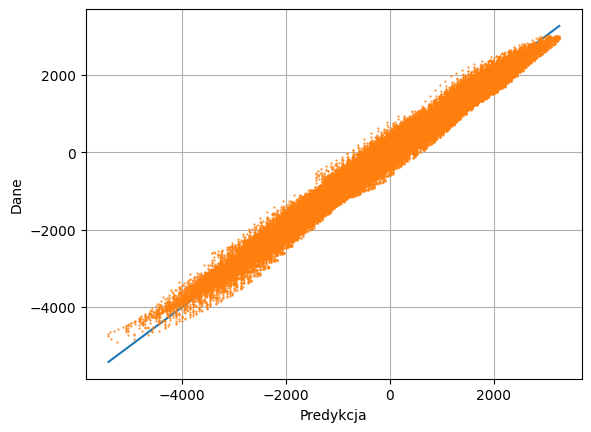

In [7]:
print(f'Train error: {(model(trainset[:][0].clone().detach().reshape(-1, 4))-trainset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean()}')
print(f'Test error: {(model(testset[:][0].clone().detach().reshape(-1, 4))-testset[:][1].reshape(-1, 1)).reshape(-1).pow(2).mean()}')
plt.plot([np.min(outs), np.max(outs)], [np.min(outs), np.max(outs)])
plt.plot(outs.reshape(-1), model(torch.cat((torch.Tensor(X).reshape(-1, 1), torch.Tensor(Y).reshape(-1, 1), torch.Tensor(Z).reshape(-1, 1), torch.Tensor(W).reshape(-1, 1)), axis=1)).detach().numpy().reshape(-1), '.', markersize=1)
plt.xlabel('Predykcja')
plt.ylabel('Dane')
plt.grid()
plt.show()